In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
from scipy import stats
import numpy as np
from pprint import pprint
import matplotlib as mpl

result = pd.read_csv("../data/din_results.csv")
result.groupby("test").describe().T

test       calibrated  calibrated_bruce_1500_512_32  \
pk  count   52.000000                     52.000000   
    mean    36.653846                     36.653846   
    std     18.090063                     18.090063   
    min      7.000000                      7.000000   
    25%     20.500000                     20.500000   
    50%     37.500000                     37.500000   
    75%     51.250000                     51.250000   
    max     68.000000                     68.000000   
age count   52.000000                     52.000000   
    mean    37.173077                     37.173077   
    std     13.840437                     13.840437   
    min     12.000000                     12.000000   
    25%     28.750000                     28.750000   
    50%     31.500000                     31.500000   
    75%     41.500000                     41.500000   
    max     73.000000                     73.000000   
srt count   52.000000                     52.000000   
    mean    -8.956044                     -6.567766   
    std      1.187123                      1.319383   
    min    -11.238095                    -11.047619   
    25%     -9.761905                     -7.238095   
    50%     -8.952381                     -6.666667   
    75%     -8.000000                     -5.714286   
    max     -6.857143                     -3.047619   

test       calibrated_specres_1500_512_32_50  
pk  count                          52.000000  
    mean                           36.653846  
    std                            18.090063  
    min                             7.000000  
    25%                            20.500000  
    50%                            37.500000  
    75%                            51.250000  
    max                            68.000000  
age count                          52.000000  
    mean                           37.173077  
    std                            13.840437  
    min                            12.000000  
    25%                            28.750000  
    50%                            31.500000  
    75%                            41.500000  
    max                            73.000000  
srt count                          52.000000  
    mean                           -1.888278  
    std                             2.110101  
    min                            -6.857143  
    25%                            -2.952381  
    50%                            -2.095238  
    75%                            -1.095238  
    max                             4.000000

# Comparison against clinical data

In [2]:
nh_data = np.array([
    (-8.8, 0.6, 23),  # Smits 2013
    (-9.3, 0.7, 16),  # Smits 2016
    (-9.5, 1.0, 12),  # de Graaf est fig 1.
    (-9.3, 0.7, 12),  # Kaandorp 2015
    (-8.4, 0.6, 18),  # Stronks 2025
])

ci_data = np.array([
    (-3.6, 1.7, 16),  # de Graaf est fig 1.
    (-1.8, 2.7, 24),  # Kaandorp 2015
    (-1.5, 2.5, 18),  # Stronks 2025
    (-1.4, 3.8, 58),  
])

def tost_from_summary(mean1, std1, nobs1, mean2, std2, nobs2, 
                      delta=1, alpha=0.05, equal_var=False):
    # Lower bound test: mean1 > mean2 - delta
    t1, p1_two_sided = stats.ttest_ind_from_stats(mean1, std1, nobs1,
                                            mean2 + delta, std2, nobs2,
                                            equal_var=equal_var)
    p1 = p1_two_sided / 2  # one-sided

    # Upper bound test: mean1 < mean2 + delta
    t2, p2_two_sided = stats.ttest_ind_from_stats(mean1, std1, nobs1,
                                            mean2 - delta, std2, nobs2,
                                            equal_var=equal_var)
    p2 = p2_two_sided / 2  # one-sided

    equivalent = p1 < alpha and p2 < alpha
    return {
        "p1": p1,
        "p2": p2,
        "max_p": max(p1, p2),
        "equivalent": equivalent
    }

for study_data, test_name in zip((nh_data, ci_data), ("calibrated", "calibrated_specres_1500_512_32_50")):
    x_hat = (study_data[:, 0] * study_data[:, 2]).sum() / study_data[:, 2].sum()
    s_hat = (study_data[:, 1] * (study_data[:, 2] - 1)).sum() / (study_data[:, 2] - 1).sum()
    snrs = result[result['test'] == test_name]['srt']
    print("mean\tstd\tn\t", test_name)
    print(x_hat, s_hat, study_data[:, 2].sum())
    print(np.mean(snrs), np.std(snrs), len(snrs))
    pprint(tost_from_summary(
        mean1=x_hat, std1=s_hat, nobs1=study_data[:, 2].sum(), 
        mean2=np.mean(snrs), std2=np.std(snrs), nobs2=len(snrs),
        delta=s_hat / 2
    ))
    print()

mean	std	n	 calibrated
-8.987654320987655 0.6921052631578949 81.0
-8.956043956043956 1.1756529949681356 52
{'equivalent': np.True_,
 'max_p': np.float64(0.042625580642464175),
 'p1': np.float64(0.019794783057838897),
 'p2': np.float64(0.042625580642464175)}

mean	std	n	 calibrated_specres_1500_512_32_50
-1.8017241379310345 3.095535714285714 116.0
-1.888278388278388 2.0897130912433863 52
{'equivalent': np.True_,
 'max_p': np.float64(0.0002361163766640244),
 'p1': np.float64(0.0002361163766640244),
 'p2': np.float64(5.0198429284270955e-05)}



# Test results

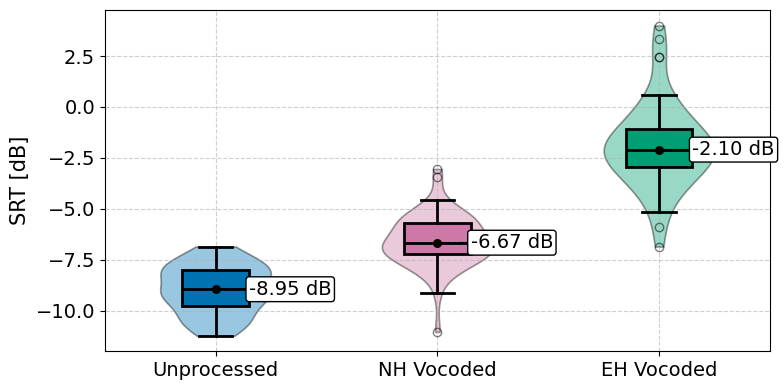

In [3]:
COLORS = ['#0072B2', '#CC79A7', '#009E73']
LABELS = ["Unprocessed", "NH Vocoded", "EH Vocoded"]

groups = result['test'].unique()
plot_data = [result[result['test'] == g]['srt'] for g in groups]

fig, ax = plt.subplots(figsize=(8, 4))

parts = ax.violinplot(
    plot_data,
    showextrema=False
)

box = ax.boxplot(
    plot_data,
    patch_artist=True,
    tick_labels=LABELS
)

for whisker in box['whiskers']:
    whisker.set(color='black', linewidth=2)
for cap in box['caps']:
    cap.set(color='black', linewidth=2)
for median in box['medians']:
    median.set(color='black', linewidth=2)
    
for flier in box['fliers']:
    flier.set(marker='o', color='red', alpha=0.5)
    
for patch, color, pc in zip(box['boxes'], COLORS, parts['bodies']):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(2)
    pc.set_facecolor(color)
    pc.set_edgecolor('black')
    pc.set_alpha(0.4)        # Transparency
    pc.set_linewidth(1.2)
    
d = .15
for i, x in enumerate(plot_data, 1):
    mean = np.median(x)
    ax.scatter(i, mean, s=30, color='black', zorder=3)
    ax.plot([i, i +d], [mean, mean], ls="dashdot", color="black", zorder=3)
    ax.text(
        i + d,
        mean,
        f"{mean:.2f} dB",
        fontsize=14,
        va="center",
        bbox = dict(
            facecolor="white",
            edgecolor="black",
            boxstyle="round",
            pad=0.15
        ),
        zorder=10 # to make sure the line is on top
    )

    
ax.grid(True, linestyle='--', alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylabel("SRT [dB]", fontsize=15)
plt.tight_layout()

[ 0.01603002 -9.55192927]
[ 0.02552813 -7.51672475]
[ 0.034524   -3.17164167]


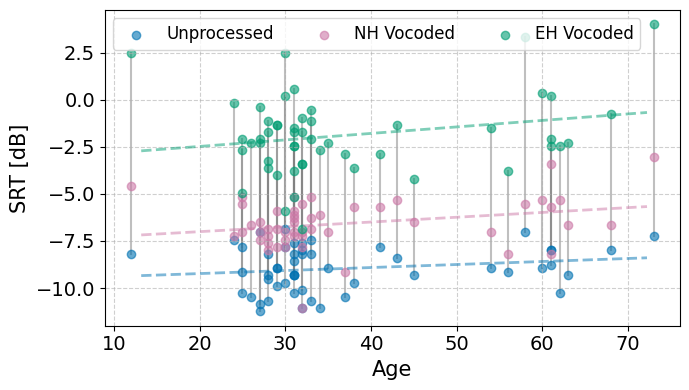

In [4]:
fig, ax = plt.subplots(figsize=(7, 4))
        
for (label, group), color, plabel in zip(result.groupby("test"), COLORS, LABELS):
    z = np.polyfit(group['age'], group['srt'], 1)
    p = np.poly1d(z)
    print(z)
    x = np.arange(group['age'].min()*1.1, group['age'].max() * 0.99)
    ax.plot(x, p(x), color=color, alpha=.5, linestyle='dashed', linewidth=2)
    ax.scatter(group['age'], group['srt'], color=color, label=plabel, alpha=.6)

for (pk, group) in result.groupby("pk"):
    age = group.iloc[0].age
    ax.plot([age, age], [group.srt.min(), group.srt.max()], 
        color='grey', alpha=.5, zorder=-10)

ax.legend(ncol=3, fontsize=12)     
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_ylabel("SRT [dB]", fontsize=15)
ax.set_xlabel("Age", fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()

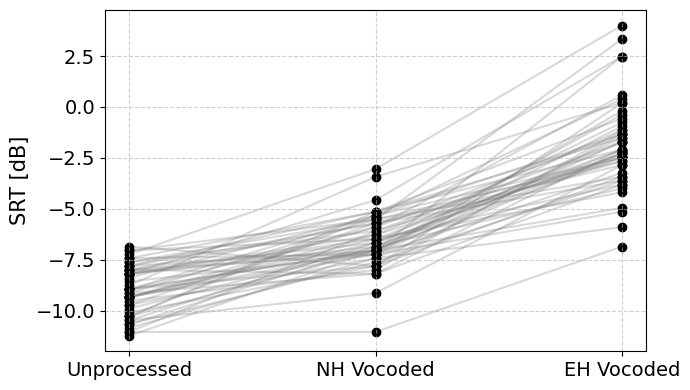

In [5]:
fig, ax = plt.subplots(figsize=(7, 4))
cmap = plt.get_cmap("nipy_spectral")
norm = mpl.colors.Normalize(vmin=result.pk.min(), vmax=result.pk.max())


for (pk, group) in result.groupby("pk"):
    color = cmap(norm(pk))
    ax.plot(group.test, group.srt, color='grey', alpha=.3, zorder=-1)
    ax.scatter(group.test, group.srt, color='black')

ax.set_xticks(range(0, 3), LABELS)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_ylabel("SRT [dB]", fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()


# Statistics

In [6]:
stat_features = pd.read_csv("../data/din_stats.csv")
stat_features

,file,bruce_abs_dist,bruce_rmse,bruce_mcd,specres_abs_dist,specres_rmse,specres_mcd
0,912.wav,4226.911782,0.005286,407.553235,8160.451334,0.008602,439.178732
1,283.wav,7025.951366,0.011478,487.031025,5769.452967,0.009310,363.610998
2,423.wav,6896.350611,0.008893,448.259567,6961.527549,0.009128,449.485451
3,157.wav,6034.576363,0.007847,344.181210,6968.442515,0.007770,430.623568
4,986.wav,6349.523686,0.009004,383.960753,7739.558546,0.009673,442.027353
...,...,...,...,...,...,...,...
115,293.wav,4670.017615,0.005993,414.986949,5683.625228,0.007387,382.762581
116,931.wav,4781.386761,0.005693,412.214132,6657.567382,0.009384,410.125828
117,916.wav,5926.984854,0.008544,315.065815,6451.389919,0.007311,386.652273
118,049.wav,5577.538732,0.005787,468.821604,6561.368482,0.007634,486.112000


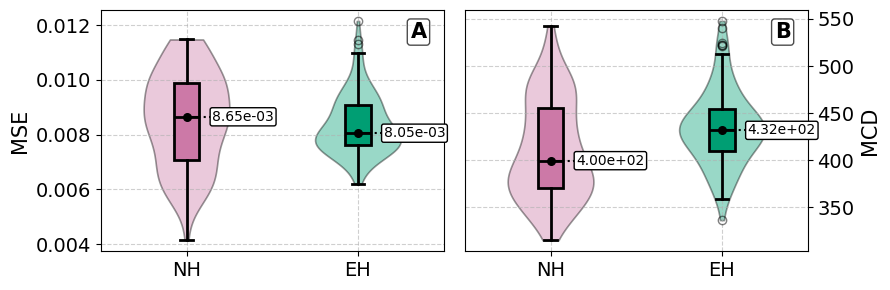

In [8]:
from scipy.stats import mannwhitneyu
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

f, (axes) = plt.subplots(1, 2, figsize=(9, 3))

pretty = {
    "rmse": "MSE",
    "mcd": "MCD"
}
for ax, feature in zip(axes, ("rmse", "mcd")):
    plot_data = stat_features[[f'bruce_{feature}', f'specres_{feature}']]
    parts = ax.violinplot(
        plot_data,
        showextrema=False
    )
    
    box = ax.boxplot(
        plot_data,
        patch_artist=True,
        tick_labels=["NH", "EH"]
    )
    
    for whisker in box['whiskers']:
        whisker.set(color='black', linewidth=2)
    for cap in box['caps']:
        cap.set(color='black', linewidth=2)
    for median in box['medians']:
        median.set(color='black', linewidth=2)
        
    for flier in box['fliers']:
        flier.set(marker='o', color='red', alpha=0.5)
        
    for patch, color, pc in zip(box['boxes'], ['#CC79A7', '#009E73'], parts['bodies']):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')
        patch.set_linewidth(2)
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(0.4)        # Transparency
        pc.set_linewidth(1.2)
        
    d = .15
    for i, x in enumerate(plot_data.values.T, 1):
        mean = np.median(x)
        ax.scatter(i, mean, s=30, color='black', zorder=3)
        ax.plot([i, i +d], [mean, mean], ls="dashdot", color="black", zorder=3)
        ax.text(
            i + d,
            mean,
            f"{mean:.2e}",
            fontsize=10,
            va="center",
            bbox = dict(
                facecolor="white",
                edgecolor="black",
                boxstyle="round",
                pad=0.15
            ),
            zorder=10 # to make sure the line is on top
        )
    
        
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    if feature == 'mcd':
        ax.yaxis.set_label_position("right")
        ax.yaxis.tick_right()
    
    stat, p_value = stats.mannwhitneyu(*plot_data.values.T, alternative='two-sided')
    
    ax.set_ylabel(pretty[feature], fontsize=15)
    # print(feature, np.round(p_value, 4))
    
for ax, label in zip(axes.ravel(), "ABCDEF"):
    ax.text(0.95, 0.95, label,
        transform=ax.transAxes,
        fontsize=15, fontweight='bold',
        va='top', ha='right',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='round,pad=0.15'))
    
        
plt.tight_layout()